C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [108.51133501259437, 79.179401063532, 63.81024349286298],
 'color_percentage': 0.2893224317979438}

Color Bar


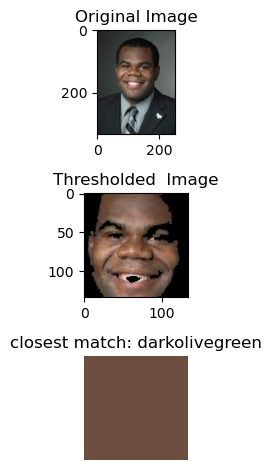

In [5]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
from webcolors import rgb_to_name

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces

def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

#     lower_threshold = np.array([0, 20, 70], dtype=np.uint8)
#     upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 100, 3), dtype="uint8")
    first_color = colorInformation[0]

    # Calculate the width for the first color based on its percentage
    width = int(first_color["color_percentage"] * color_bar.shape[1])

    # Get the color as a tuple
    color = tuple(map(int, first_color['color']))
    
    

    # Create a rectangle for the first color
    cv2.rectangle(color_bar, (0, 0), (100, 100), color, -1)

    # Add the color name as text
#     cv2.putText(color_bar, color, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return color_bar, color


"""## Section Two.4.2 : Putting it All together: Pretty Print

The function makes print out the color information in a readable manner
"""


def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()
        break




# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
# image = imutils.url_to_image(
#     "https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg")

image=cv2.imread("1.jpeg")

# Resize image to a width of 250
image = imutils.resize(image, width=250)

# Show image
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

faces = detect_faces(image)

# Loop through the detected faces and detect skin color in each face region
for (x, y, w, h) in faces:
    face_roi = image[y:y+h, x:x+w]
    skin = extractSkin(face_roi)
    plt.subplot(3, 1, 2)
    plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
    plt.title("Thresholded  Image")
    # Display the colored skin mask
#     cv2.imshow('Colored Skin Color Mask', colored_mask)
#     cv2.waitKey(0)

# Apply Skin Mask
# skin = extractSkin(image)

# plt.subplot(3, 1, 2)
# plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
# plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)

# Show in the dominant color as bar
print("Color Bar")
colour_bar, color_name = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)

rgb_color_int = tuple(map(int, color_name))

from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)
def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    
    kdt_db = KDTree(rgb_values)
    distance, index = kdt_db.query(rgb_tuple)
    return f'closest match: {names[index]}'

# Find the closest English color name
closest_color = convert_rgb_to_names(rgb_color_int)
plt.title(closest_color)

plt.tight_layout()
plt.show()

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 2,
 'color': [86.91666666666666, 66.5, 51.583333333333336],
 'color_percentage': 0.2727272727272727}

Color Bar


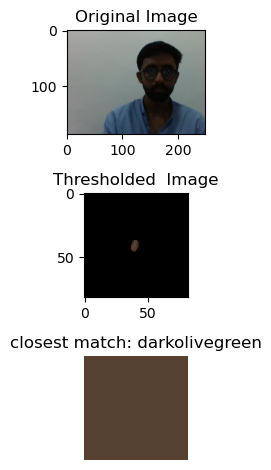

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [81.65517241379311, 59.75862068965515, 44.20689655172414],
 'color_percentage': 0.3972602739726027}

Color Bar


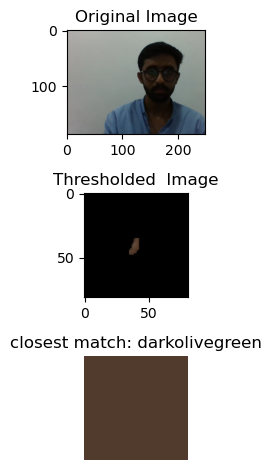

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [81.55555555555559, 57.703703703703724, 42.74074074074074],
 'color_percentage': 0.3698630136986301}

Color Bar


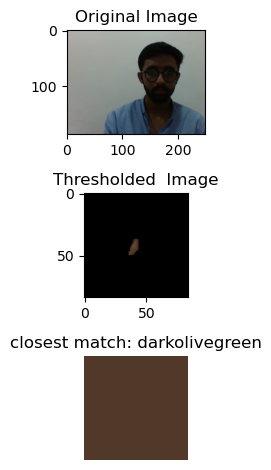

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [81.52380952380952, 57.33333333333334, 41.904761904761905],
 'color_percentage': 0.39622641509433965}

Color Bar


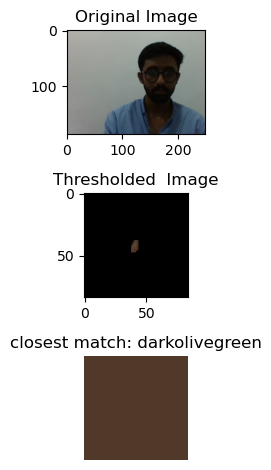

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [81.52380952380952, 57.33333333333334, 41.904761904761905],
 'color_percentage': 0.39622641509433965}

Color Bar


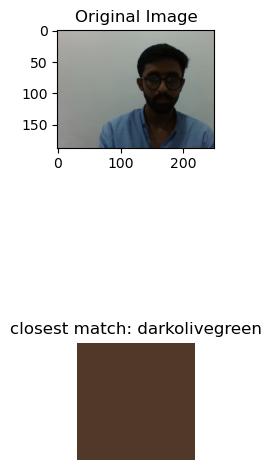

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [81.52380952380952, 57.33333333333334, 41.904761904761905],
 'color_percentage': 0.39622641509433965}

Color Bar


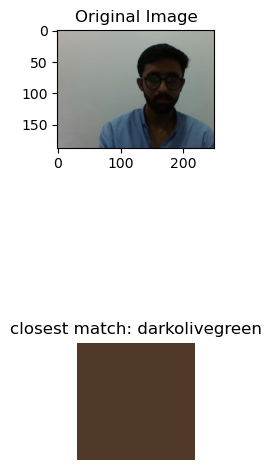

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information
{'cluster_index': 0,
 'color': [79.80769230769232, 55.6923076923077, 42.11538461538462],
 'color_percentage': 0.4126984126984127}

Color Bar


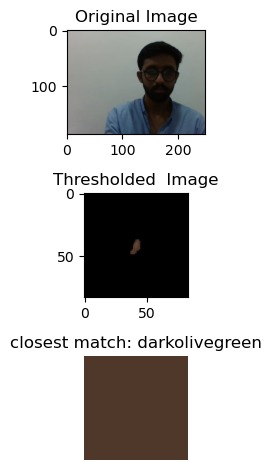

In [7]:
cv2.namedWindow('Camera Output')

# Get pointer to video frames from primary device
videoFrame = cv2.VideoCapture(0)

# Process the video frames
keyPressed = -1 # -1 indicates no key pressed

while(keyPressed < 0): # any key pressed has a value >= 0

    # Grab video frame, decode it and return next video frame
    readSucsess, image = videoFrame.read()

    image = imutils.resize(image, width=250)

# Show image
    plt.subplot(3, 1, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
# plt.show()

    faces = detect_faces(image)

# Loop through the detected faces and detect skin color in each face region
    for (x, y, w, h) in faces:
        face_roi = image[y:y+h, x:x+w]
        skin = extractSkin(face_roi)
        plt.subplot(3, 1, 2)
        plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
        plt.title("Thresholded  Image")
    # Display the colored skin mask
#     cv2.imshow('Colored Skin Color Mask', colored_mask)
#     cv2.waitKey(0)

# Apply Skin Mask
# skin = extractSkin(image)

# plt.subplot(3, 1, 2)
# plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
# plt.title("Thresholded  Image")
# plt.show()

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
    dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
    print("Color Information")
    prety_print_data(dominantColors)

# Show in the dominant color as bar
    print("Color Bar")
    colour_bar, color_name = plotColorBar(dominantColors)
    plt.subplot(3, 1, 3)
    plt.axis("off")
    plt.imshow(colour_bar)

    rgb_color_int = tuple(map(int, color_name))

    from scipy.spatial import KDTree
    from webcolors import (
        CSS3_HEX_TO_NAMES,
        hex_to_rgb,
    )
    def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
        css3_db = CSS3_HEX_TO_NAMES
        names = []
        rgb_values = []
        for color_hex, color_name in css3_db.items():
            names.append(color_name)
            rgb_values.append(hex_to_rgb(color_hex))
    
        kdt_db = KDTree(rgb_values)
        distance, index = kdt_db.query(rgb_tuple)
        return f'closest match: {names[index]}'

# Find the closest English color name
    closest_color = convert_rgb_to_names(rgb_color_int)
    plt.title(closest_color)

    plt.tight_layout()
    plt.show()

    # Display the source image
    cv2.imshow('Camera Output',image)

    # Check for user input to close program
    keyPressed = cv2.waitKey(1) # wait 1 milisecond in each iteration of while loop

# Close window and camera after exiting the while loop
cv2.destroyWindow('Camera Output')
videoFrame.release()